In [48]:
import torch
from transformers import AutoTokenizer, BigBirdForMaskedLM, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

tokenizer = AutoTokenizer.from_pretrained("google/bigbird-roberta-base")
model = BigBirdForMaskedLM.from_pretrained("google/bigbird-roberta-base")

In [23]:
tokenizer.encode('Twist Bioscience Corporation')

[65, 44189, 16125, 16902, 10602, 66]

In [24]:
import pandas as pd
MLM_data_train = pd.read_csv('/Users/sonhyeongjin/Desktop/project/quant competition/data/processingdata/MLM_data_K_train.csv')
MLM_data_test = pd.read_csv('/Users/sonhyeongjin/Desktop/project/quant competition/data/processingdata/MLM_data_K_test.csv')

In [25]:
MLM_data_train['companyName'].value_counts()

companyName
Twist Bioscience Corporation    155
Amgen Inc.                      142
Gilead Sciences, Inc.           137
AbbVie Inc.                     129
Biogen Inc.                     126
                               ... 
Carisma Therapeutics, Inc.        1
Noile-Immune Biotech Inc.         1
Ablynx NV                         1
Eidos Therapeutics, Inc.          1
Apogee Therapeutics, Inc.         1
Name: count, Length: 1356, dtype: int64

In [26]:
tokenizer.encode('Twist Bioscience Corporation')

[65, 44189, 16125, 16902, 10602, 66]

In [27]:
unique_company = list(MLM_data_train['companyName'].unique())
tokenizer.add_tokens(unique_company)
model.resize_token_embeddings(len(tokenizer))

Embedding(51714, 768)

In [28]:
company_counts = MLM_data_train['companyName'].value_counts()

# 데이터셋 생성
filtered_data = pd.DataFrame()

for company, count in company_counts.items():
    if count == 1:
        # 빈도가 1인 기업은 1개만 선택
        company_data = MLM_data_train[MLM_data_train['companyName'] == company].head(1)
    else:
        # 빈도가 2개 이상인 기업은 최대 2개만 선택
        company_data = MLM_data_train[MLM_data_train['companyName'] == company].head(2)

    filtered_data = pd.concat([filtered_data, company_data], ignore_index=True)


In [29]:
input_articles = MLM_data_train['masked_situation'].tolist()
input_labels = MLM_data_train['situation'].tolist()

In [30]:
input_articles = filtered_data['masked_situation'].tolist()
input_labels = filtered_data['situation'].tolist()

In [31]:
filtered_data

,Unnamed: 0,companyId,companyName,keyDevId,headline,situation,announcedDate,mostImportantDateUTC,keyDevEventTypeName,masked_situation
0,52531,242825322,Twist Bioscience Corporation,1800670121,Twist Bioscience Corporation Presents at 14TH ...,Twist Bioscience Corporation Presents at 14TH ...,2022-09-15 02:51:00,2022-11-09 00:00:00,Company Conference Presentations,[MASK] Presents at 14TH ANNUAL NEXT GENERATION...
1,52533,242825322,Twist Bioscience Corporation,1800670120,Twist Bioscience Corporation Presents at ELRIG...,Twist Bioscience Corporation Presents at ELRIG...,2022-09-15 02:51:00,2022-11-02 00:00:00,Company Conference Presentations,[MASK] Presents at ELRIG Protein Sciences in D...
2,603,24816,Amgen Inc.,1800785670,Amgen Inc. Presents at PDA Pharmaceutical Micr...,Amgen Inc. Presents at PDA Pharmaceutical Micr...,2022-09-16 14:25:00,2022-10-11 18:10:00,Company Conference Presentations,[MASK] Presents at PDA Pharmaceutical Microbio...
3,604,24816,Amgen Inc.,1800785544,Amgen Inc. Presents at BioProcess Internationa...,Amgen Inc. Presents at BioProcess Internationa...,2022-09-16 12:01:00,2022-09-27 00:00:00,Company Conference Presentations,"[MASK] Presents at BioProcess International, S..."
4,2975,29002,"Gilead Sciences, Inc.",1801148634,"Gilead Sciences, Inc. (NasdaqGS:GILD) complete...","Gilead Sciences, Inc. (NasdaqGS:GILD) entered ...",2022-09-20 00:00:00,2022-09-20 00:00:00,M&A Transaction Closings,[MASK] (NasdaqGS:GILD) entered into a definiti...
...,...,...,...,...,...,...,...,...,...,...
2626,73011,433272951,"Carisma Therapeutics, Inc.",1772786516,"Carisma Therapeutics, Inc. has filed a Shelf R...","Carisma Therapeutics, Inc. has filed a Shelf R...",2022-02-28 00:00:00,2022-02-28 05:00:00,Shelf Registration Filings,[MASK] has filed a Shelf Registration in the a...
2627,73666,536457283,Noile-Immune Biotech Inc.,1769702026,"Legend Biotech USA, Inc. and Noile-Immune Biot...",Legend Biotech USA Inc. and Noile-Immune Biote...,2022-02-02 21:02:00,2022-02-02 21:02:00,Strategic Alliances,Legend Biotech USA Inc. and [MASK] have mutual...
2628,17063,3182703,Ablynx NV,1797675219,Ablynx NV Presents at Festival of Biologics Ba...,Ablynx NV Presents at Festival of Biologics Ba...,2022-08-23 12:31:00,2022-11-04 10:30:00,Company Conference Presentations,[MASK] Presents at Festival of Biologics Basel...
2629,74059,539024074,"Eidos Therapeutics, Inc.",1799538470,"Eidos Therapeutics, Inc. Presents at 21st Annu...","Eidos Therapeutics, Inc. Presents at 21st Annu...",2022-09-03 18:06:00,2022-09-23 12:30:00,Company Conference Presentations,[MASK] Presents at 21st Annual Contracting & O...


In [32]:
input_articles[-1]

'[MASK] announced that it has raised $20 million in a round of funding led by new investor Fairmount Funds Management LLC in 2021. The transaction included participation from new investor VR Adviser, LLC. '

In [33]:
encode_art

{'input_ids': tensor([[   65,    67,  3515,   427,   441,   569,  4477,   821,  1339,  1611,
           388,   358,  2936,   387,  5019,  3058,   517,   750, 15912,  7112,
         15049, 34169,  8650, 11520,   388, 33549,   114,   484,  8712,  3118,
         10371,   523,   750, 15912,  6554, 47762,   112, 11520,   114,   321,
            66]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [34]:
from tqdm import tqdm
list_1 =[]

for article in tqdm(input_articles):
    encode_art = (tokenizer.encode_plus(article, add_special_tokens=True, return_tensors='pt'))
    list_1.append(encode_art['input_ids'][0].size()[0])

max(list_1)   

100%|██████████| 2631/2631 [00:00<00:00, 3020.73it/s]


1720

In [35]:
max_length = 1000
#이건 문장 전체 길이max_length_1 = 1842

In [36]:
from tqdm import tqdm
input_ids = []
attention_masks = []
label_ids = []

for article in tqdm(input_articles):
    encoded_article = tokenizer.encode_plus(article, add_special_tokens=True, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
    encoded_article['input_ids'][encoded_article['input_ids'] != tokenizer.mask_token_id] = -100
    input_ids.append(encoded_article['input_ids'])
    attention_masks.append(encoded_article['attention_mask'])

for article in tqdm(input_labels):
    encoded_article = tokenizer.encode_plus(article, add_special_tokens=True, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
    label_ids.append(encoded_article['input_ids'])

100%|██████████| 2631/2631 [00:01<00:00, 2043.02it/s]


## -100 넣어서 나머지 loss계산 안하기


In [37]:
input_ids = torch.stack(input_ids)
attention_masks = torch.stack(attention_masks)
label_ids = torch.stack(label_ids)

In [38]:

input_ids = input_ids.view(input_ids.size()[0], max_length)
attention_masks = attention_masks.view(input_ids.size()[0],max_length)
label_ids = label_ids.view(input_ids.size()[0],max_length)

In [39]:
learning_rate = 1e-5
num_epochs = 2

# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=learning_rate)

model.train()
device = torch.device("mps")
model.to(device)

/Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BigBirdForMaskedLM(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(51714, 768)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): D

In [40]:
batch_size = 1
data = TensorDataset(input_ids, attention_masks, label_ids)

train_dataloader = DataLoader(data, batch_size=batch_size,shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [41]:
num_epochs = 100
loss_list = []

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for batch in train_dataloader:
        input_ids_batch, attention_mask_batch, label_ids_batch = batch
        input_ids_batch = input_ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)
        label_ids_batch = label_ids_batch.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels = label_ids_batch)
        
        loss = outputs.loss
        #list_1.append(loss)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 에포크 평균 손실 계산
    avg_loss = total_loss / len(train_dataloader)
    loss_list.append(avg_loss)
    # 에포크별 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

        

  0%|          | 0/100 [06:07<?, ?it/s]


KeyboardInterrupt: 

## MASK 된 부분만 loss값 계산
## 잘 훈련됬다면 그 값만 출력

In [471]:
import matplotlib.pyplot as plt

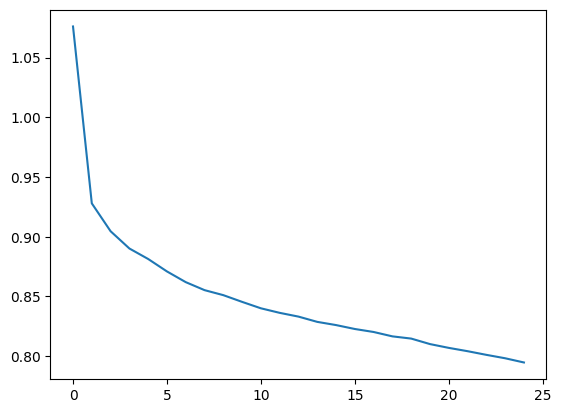

In [472]:
plt.plot(loss_list)

## 이게 학습 할만한 데이터인가??? 이건 강화학습으로 푸는게 맞아보이는데 보상이 있어야하지 않을까? 이건 조금 고민해보자 강화학습이 어떨때 유리할까?

In [473]:
model_path = 'model_bin/2000shot 20epoch'

In [1180]:
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('model_bin/2000shot 20epoch/tokenizer_config.json',
 'model_bin/2000shot 20epoch/special_tokens_map.json',
 'model_bin/2000shot 20epoch/spiece.model',
 'model_bin/2000shot 20epoch/added_tokens.json',
 'model_bin/2000shot 20epoch/tokenizer.json')

In [1184]:
tokenizer.encode('Twist Bioscience Corporation')

[65, 44189, 16125, 16902, 10602, 66]

In [1183]:
import torch
from transformers import AutoTokenizer, BigBirdForMaskedLM, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = BigBirdForMaskedLM.from_pretrained(model_path)

In [476]:
#input_articles_test = MLM_data_test['masked_situation'].tolist()
input_articles_test = MLM_data_train['masked_situation'].tolist()

In [477]:
max_length = 1842

In [479]:
input_ids = []
attention_masks = []
label_ids = []

for article in tqdm(input_articles_test):
    encoded_article = tokenizer.encode_plus(article, add_special_tokens=True, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
    input_ids.append(encoded_article['input_ids'])
    attention_masks.append(encoded_article['attention_mask'])

for article in tqdm(input_articles_test):
    encoded_article = tokenizer.encode_plus(article, add_special_tokens=True, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt')
    label_ids.append(encoded_article['input_ids'])

  0%|          | 0/33199 [00:00<?, ?it/s]

100%|██████████| 33199/33199 [00:22<00:00, 1448.71it/s]


In [480]:
input_ids = torch.stack(input_ids)
attention_masks = torch.stack(attention_masks)
label_ids = torch.stack(label_ids)

input_ids = input_ids.view(input_ids.size()[0], max_length)
attention_masks = attention_masks.view(input_ids.size()[0],max_length)
label_ids = label_ids.view(input_ids.size()[0],max_length)
learning_rate = 1e-5

# 옵티마이저 및 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=learning_rate)

batch_size = 1
data = TensorDataset(input_ids, attention_masks, label_ids)

test_dataloader = DataLoader(data, batch_size=batch_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

/Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [481]:
logits_tensor = []
check = []
check_1 = []
check_2 = []
device = torch.device("mps")
model.to(device)
model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids_batch_test, test_mask_batch_test,a = batch
        input_ids_batch_test = input_ids_batch_test.to(device)
        test_mask_batch_test = test_mask_batch_test.to(device)
        #test_labels_test_batch = test_labels_test_batch.to(device) 
        
        logits = model(input_ids_batch_test.view(1,1842), test_mask_batch_test.view(1,1842)).logits
        
        #check_1.append(logits.cpu())
        mask_token_index = (input_ids_batch_test == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
        #check.append(mask_token_index.cpu())
        #print(mask_token_index)
        if isinstance(mask_token_index, torch.Tensor) and mask_token_index.numel() > 0:
            #check.append(logits)
            #check_1.append(mask_token_index)
            predicted_token_id = logits[0, mask_token_index[0].item()].argmax(axis=-1)
            logits_tensor.append(logits.view(1842,51714)[mask_token_index[0].item()].cpu())
            #check_2.append(predicted_token_id)

        else:
            logits_tensor.append(-1)
        torch.mps.empty_cache()

100%|██████████| 33199/33199 [1:32:03<00:00,  6.01it/s]


In [875]:
logits_tensor

[tensor([-7.8912, -6.1869, -5.4470,  ...,  2.7256,  2.9407,  2.2981]),
 tensor([-7.6584, -5.8020, -6.0892,  ...,  3.1721,  2.9262,  2.6843]),
 tensor([-8.0547, -6.0352, -6.4074,  ...,  2.9857,  2.8098,  2.4316]),
 tensor([-5.0758, -6.6624, -6.0040,  ...,  0.8686,  1.6276,  1.4468]),
 tensor([-4.6331, -5.8559, -5.2126,  ...,  0.8229,  1.2559,  1.8604]),
 tensor([-2.0514, -7.1868, -6.0785,  ...,  0.1518, -0.3717,  1.8318]),
 tensor([-6.5204, -6.6137, -6.2673,  ...,  2.1585,  2.5200,  2.1481]),
 tensor([-6.0103, -5.2182, -4.9742,  ...,  1.8202,  2.3945,  0.7469]),
 tensor([-6.4047, -5.3234, -4.1196,  ...,  2.2254,  2.6369,  1.1833]),
 tensor([-6.3712, -5.6721, -6.8558,  ...,  2.7095,  1.7809,  2.3611]),
 tensor([-4.2026, -6.7530, -6.0536,  ...,  0.2751,  1.2796,  1.0134]),
 tensor([-6.0885, -5.5942, -4.9236,  ...,  1.9425,  2.4665,  2.1694]),
 tensor([-6.2389, -5.2940, -4.0076,  ...,  2.1694,  2.5574,  1.1530]),
 tensor([-8.2149, -5.9016, -6.0711,  ...,  3.1431,  3.8216,  2.6585]),
 tenso

In [482]:
import pickle
with open('data/few_shot_2000_unprocessing_logits_output.pickle','wb') as file:
    pickle.dump(logits_tensor,file)

In [484]:
with open('data/few_shot_2000_unprocessing_logits_output.pickle','rb') as file:
    loaded_list = pickle.load(file)


In [485]:
list_1 = []
for i in logits_tensor:
    try:
        torch.argmax(i)
        a = tokenizer.decode(torch.argmax(i))
        list_1.append(a)
    except:
        pass

In [509]:
list_1

['Emergent Health Corp',
 'ZyVersa Therapeutics, Inc.',
 'ZyVersa Therapeutics, Inc.',
 '',
 'Genfit S.A.',
 '',
 'ZyVersa Therapeutics, Inc.',
 'Genfit S.A.',
 'Renovacor, Inc.',
 'Zura Bio Limited',
 '',
 'AquaBounty Technologies, Inc.',
 'Renovacor, Inc.',
 'MDxHealth SA',
 'ZyVersa Therapeutics, Inc.',
 'ZyVersa Therapeutics, Inc.',
 'ARS Pharmaceuticals, Inc.',
 '',
 '',
 '',
 'Emergent Health Corp',
 'Renovacor, Inc.',
 'Genfit S.A.',
 '',
 'ZyVersa Therapeutics, Inc.',
 'ZyVersa Therapeutics, Inc.',
 'UnicoCell Biomed Co., Ltd.',
 'Renovacor, Inc.',
 'Genfit S.A.',
 'ZyVersa Therapeutics, Inc.',
 'Lixte Biotechnology Holdings, Inc.',
 'ARS Pharmaceuticals, Inc.',
 'Zura Bio Limited',
 '',
 '',
 'Renovacor, Inc.',
 '',
 'Genfit S.A.',
 '',
 'Jiangsu Aidea Pharmaceutical Co., Ltd.',
 'Genfit S.A.',
 'MDxHealth SA',
 'Emergent Health Corp',
 '',
 '',
 'Lixte Biotechnology Holdings, Inc.',
 'Renovacor, Inc.',
 'AquaBounty Technologies, Inc.',
 'Arctic Bioscience AS',
 '',
 'Zura Bio

In [827]:
import pickle
with open('/Users/sonhyeongjin/Desktop/quant competition/model_mps/sentiment/data/finbert-tone','rb') as file:
    loaded_data = pickle.load(file)

In [828]:
import torch.nn.functional as F
a = []
count = 0
for i in range(len(logits_tensor)):
    a.append(F.softmax(logits_tensor[i][50358::]))
    

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_76875/3288533473.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a.append(F.softmax(logits_tensor[i][50358::]))


In [879]:
a

[tensor([0.0003, 0.0002, 0.0014,  ..., 0.0002, 0.0003, 0.0002]),
 tensor([0.0004, 0.0003, 0.0009,  ..., 0.0003, 0.0003, 0.0002]),
 tensor([0.0005, 0.0003, 0.0009,  ..., 0.0003, 0.0003, 0.0002]),
 tensor([3.2572e-04, 1.8390e-04, 2.3218e-03,  ..., 9.9505e-05, 2.1255e-04,
         1.7739e-04]),
 tensor([0.0004, 0.0001, 0.0047,  ..., 0.0001, 0.0002, 0.0003]),
 tensor([0.0005, 0.0002, 0.0004,  ..., 0.0002, 0.0001, 0.0013]),
 tensor([0.0003, 0.0002, 0.0009,  ..., 0.0002, 0.0003, 0.0002]),
 tensor([3.1913e-04, 1.4447e-04, 6.5546e-03,  ..., 1.4493e-04, 2.5738e-04,
         4.9549e-05]),
 tensor([1.4496e-04, 1.7674e-04, 4.4206e-03,  ..., 1.7133e-04, 2.5858e-04,
         6.0435e-05]),
 tensor([0.0005, 0.0002, 0.0010,  ..., 0.0003, 0.0001, 0.0002]),
 tensor([3.0846e-04, 1.4212e-04, 2.8526e-03,  ..., 8.2694e-05, 2.2580e-04,
         1.7303e-04]),
 tensor([0.0004, 0.0002, 0.0033,  ..., 0.0002, 0.0003, 0.0002]),
 tensor([1.4445e-04, 1.7792e-04, 4.4799e-03,  ..., 1.7061e-04, 2.5147e-04,
         6.17

In [1230]:
import torch
from scipy.stats import ks_2samp
from scipy import stats
from scipy.stats import chi2_contingency
import numpy as np
from scipy.stats import ks_2samp, uniform
# 두 분포 간의 t-테스

# 확률값이 들어있는 텐서 생성 (예: 균일 분포)
uniform_distribution = torch.ones(30000) / 30000  # 균일 분포

# 다른 확률값을 포함하는 텐서 생성
# 예를 들어, [0.1, 0.2, 0.3, 0.4]와 같이 사용자가 설정한 확률값이 들어있는 텐서

# PyTorch 텐서를 NumPy 배열로 변환
b={'vocab_tensor':[],'var':[],'label_prob':[]}
uniform_data = np.random.uniform(0, 1, size=len(data))
import json
for index,i in tqdm(enumerate(a)):


    # 주어진 데이터를 numpy 배열로 변환
    data_1 = np.array(i)

    # 주어진 데이터를 기반으로 CDF 추정
    empirical_cdf = np.cumsum(data_1) / np.sum(data_1)

    # 균등분포를 따르는 이론적인 데이터 생성
    uniform_data = np.random.uniform(0, 1, size=len(data_1))

    # 이론적인 데이터를 기반으로 CDF 추정
    uniform_cdf = np.cumsum(uniform_data) / np.sum(uniform_data)

    # KS 검정 수행
    var = torch.var(i)
    company_number = tokenizer.encode(MLM_data_train['companyName'][index])[1]
    label_prob = a[index][company_number-50358]
    # KS 검정 수행
    #chi2, p, _, _= chi2_contingency(uniform_np, custom_np)
    b['vocab_tensor'].append(i.tolist())
    b['var'].append(var)
    b['label_prob'].append(label_prob.item())
        

    


33199it [00:02, 13551.44it/s]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 예시 데이터 생성


# Min-Max 정규화를 위한 scaler 생성
scaler = MinMaxScaler()

# 데이터를 2D 배열로 변환 후 정규화
data_array_label = [[x] for x in b['label_prob']] 
data_array_var = [[x] for x in b['var']]  # MinMaxScaler는 2D 배열을 입력
normalized_label = scaler.fit_transform(data_array_label)
normalized_var = scaler.fit_transform(data_array_var)

In [1232]:
normalized_var.flatten()[:10]

array([0.00318839, 0.00262258, 0.00270897, 0.00596759, 0.02307411,
       0.03726474, 0.00476593, 0.0261543 , 0.01387242, 0.00834472])

In [1233]:
pd.DataFrame(loaded_data).value_counts()

 0    29225
-1     2579
 1     1395
Name: count, dtype: int64

In [1234]:
min(senti_score)

-0.0006823556246162362

In [1235]:
senti_score = np.array(b['label_prob']) * np.array(loaded_data) * np.array(b['var'])
extened_data =  MLM_data_train.copy()
extened_data['senti_score'] = senti_score

In [1236]:
extened_data

,Unnamed: 0,companyId,companyName,keyDevId,headline,situation,announcedDate,mostImportantDateUTC,keyDevEventTypeName,masked_situation,senti_score
0,33,24153,Vericel Corporation,1800785669,Vericel Corporation Presents at PDA Pharmaceut...,Vericel Corporation Presents at PDA Pharmaceut...,2022-09-16 14:25:00,2022-10-10 21:30:00,Company Conference Presentations,[MASK] Presents at PDA Pharmaceutical Microbio...,0.000000e+00
1,35,24153,Vericel Corporation,1800102730,Vericel Corporation Presents at H.C. Wainwrigh...,Vericel Corporation Presents at H.C. Wainwrigh...,2022-09-09 20:02:00,2022-09-14 14:00:00,Company Conference Presentations,[MASK] Presents at H.C. Wainwright 24th Annual...,0.000000e+00
2,36,24153,Vericel Corporation,1798658258,Vericel Corporation Presents at Ladenburg Thal...,Vericel Corporation Presents at Ladenburg Thal...,2022-08-30 18:20:00,2022-09-29 18:30:00,Company Conference Presentations,[MASK] Presents at Ladenburg Thalmann Healthca...,0.000000e+00
3,39,24153,Vericel Corporation,1794118420,Vericel Corporation Reports Earnings Results f...,Vericel Corporation reported earnings results ...,2022-08-03 11:55:00,2022-08-03 11:55:00,Announcements of Earnings,[MASK] reported earnings results for the secon...,0.000000e+00
4,40,24153,Vericel Corporation,1794116001,Vericel Corporation Announces Revenue Guidance...,Vericel Corporation announced revenue guidance...,2022-08-03 11:55:00,2022-08-03 11:55:00,Corporate Guidance - New/Confirmed,[MASK] announced revenue guidance for the full...,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
33194,91777,1797302335,"Biocytogen Pharmaceuticals (Beijing) Co., Ltd.",1777565952,"Biocytogen Pharmaceuticals (Beijing) Co., Ltd....","Biocytogen Pharmaceuticals (Beijing) Co., Ltd....",2022-04-08 13:00:00,2022-04-08 13:00:00,Client Announcements,[MASK] announced that they have reached an agr...,0.000000e+00
33195,91778,1797302335,"Biocytogen Pharmaceuticals (Beijing) Co., Ltd.",1775873271,"Biocytogen Pharmaceuticals (Beijing) Co., Ltd....","Biocytogen Pharmaceuticals (Beijing) Co., Ltd....",2022-03-28 13:30:00,2022-03-28 13:30:00,Business Expansions,[MASK] announced the opening of the Biocytogen...,0.000000e+00
33196,91779,1797302335,"Biocytogen Pharmaceuticals (Beijing) Co., Ltd.",1774126759,"Nanjing Chia Tai Tianqing Pharmaceutical Co., ...",The board of directors of Sino Biopharmaceutic...,2022-03-10 22:31:00,2022-03-10 22:31:00,Strategic Alliances,The board of directors of Sino Biopharmaceutic...,1.837909e-10
33197,91782,1797302335,"Biocytogen Pharmaceuticals (Beijing) Co., Ltd.",1760766541,"Biocytogen Pharmaceuticals (Beijing) Co., Ltd....","Biocytogen Pharmaceuticals (Beijing) Co., Ltd....",2021-12-07 13:49:00,2022-01-10 00:00:00,Company Conference Presentations,"[MASK] Presents at 2022 Biotech Showcase, Jan-...",0.000000e+00
